# Data modelling and model building

Building data models to predict pollution

## Data loading and preparation

In [35]:
import pandas as pd
# Load the data
data = pd.read_csv('../Combined data/combined_data_hourly_2023.csv')

data = data.iloc[:, :11].join(data[['Celle 11', 'Celle 12', 'Celle 16', 'Celle 17', 'Celle 18', 'Celle 22', 'Celle 23']])

# Rename column 'celle 11' and 'celle 12' to 'OK' and 'NOK'
data.rename(columns={'Celle 11': 'Traffic east', 'Celle 12': 'Traffic north-east', 'Celle 18': 'Traffic north-west',
                     'Celle 17': 'Traffic Hvidover', 'Celle 23': 'Traffic west', 'Celle 22': 'Traffic south-west',
                     'Celle 16': 'Traffic south-east'}, inplace=True)

print(data.head())

  Weekday        Date  Hour   NO2_ppb    NOx_ppb   Temp_dry   Humidity  \
0  Sunday  2023-01-01     0  9.609539  14.333718   8.083333  98.500000   
1  Sunday  2023-01-01     1  2.431203   2.601390   9.516667  97.500000   
2  Sunday  2023-01-01     2  1.794863   1.888760  10.200000  95.000000   
3  Sunday  2023-01-01     3  1.286549   1.169177  10.033333  95.666667   
4  Sunday  2023-01-01     4  1.020709   0.850521  10.166667  95.000000   

   wind_speed     Pressure   visibility  Wind_dir Traffic east  \
0    5.600000  1000.050000  3600.000000     189.0         3,68   
1    6.600000   999.616667  4250.000000     188.0         1,84   
2   10.633333   999.666667  4550.000000     223.0         0,92   
3   10.300000   999.866667  3566.666667     228.0         0,00   
4   10.300000  1000.300000  3650.000000     232.0         0,00   

  Traffic north-east Traffic south-east Traffic Hvidover Traffic north-west  \
0               8,28               0,92             2,76               4,60   


Missing values

Missing values count in each column:
Weekday                 0
Date                    0
Hour                    0
NO2_ppb               109
NOx_ppb               261
Temp_dry                1
Humidity                1
wind_speed              1
Pressure                1
visibility              0
Wind_dir                1
Traffic east            0
Traffic north-east      0
Traffic south-east      0
Traffic Hvidover        0
Traffic north-west      0
Traffic south-west      0
Traffic west            0
dtype: int64


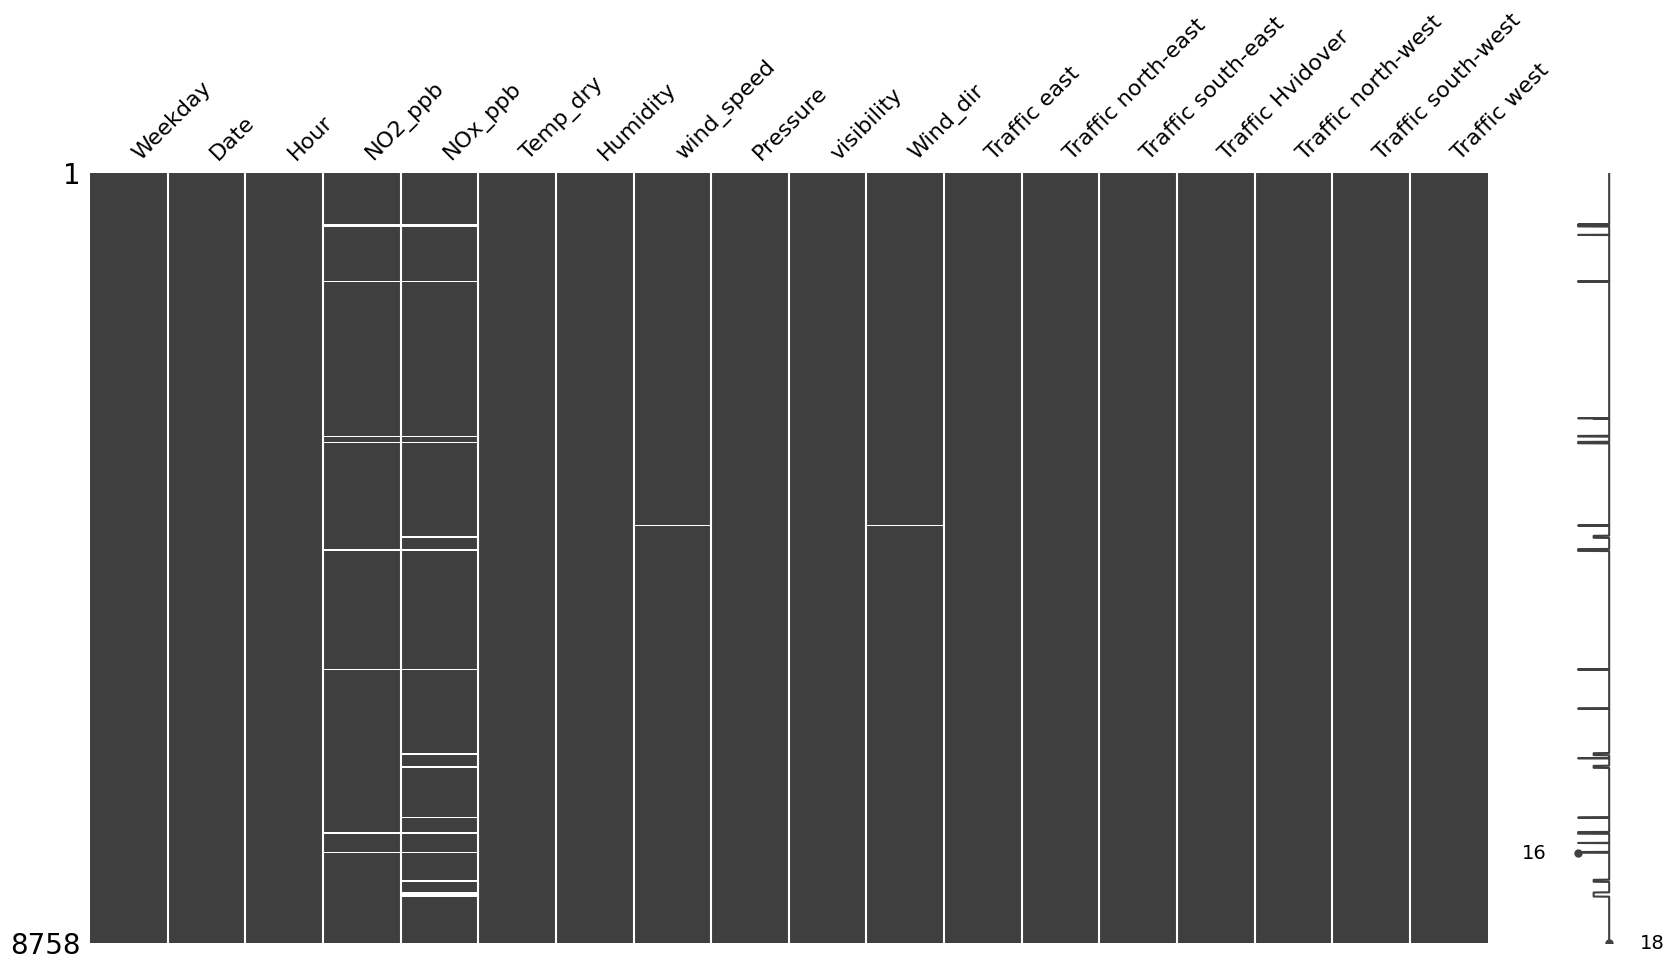

Data after dropping rows with missing values:
Weekday               0
Date                  0
Hour                  0
NO2_ppb               0
NOx_ppb               0
Temp_dry              0
Humidity              0
wind_speed            0
Pressure              0
visibility            0
Wind_dir              0
Traffic east          0
Traffic north-east    0
Traffic south-east    0
Traffic Hvidover      0
Traffic north-west    0
Traffic south-west    0
Traffic west          0
dtype: int64


In [ ]:
# Count rows with missing values
missing_values_count = data.isnull().sum()
print("Missing values count in each column:")
print(missing_values_count)

# Visualize the missing data
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(data, figsize=(20, 10))
plt.show()

# Drop rows with missing values
data.dropna(inplace=True)
missing_values_count = data.isnull().sum()
print("Data after dropping rows with missing values:")
print(missing_values_count)

# Consider using KNN to impute missing values instead.

Splitting into training and testing set.

In [37]:
# Split the data into train and test sets
train_data = data[data['Date'] < '2023-10-01']
test_data = data[data['Date'] >= '2023-10-01']

Data visualization

## Modelling

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression    # Requires package scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv('../Combined data/combined_data_hourly_2020.csv')

#X and Y 
X = data[['temp_dry','Humidity','Wind_speed','Pressure','Visibility','Wind_dir']]  
y = data['NO2_ppb'] 

# Split the data into training and testing sets
split_index = int(len(X) * 0.8)

# Chronological split
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

###DATA PREPARATION LIKE CARET#####

# Impute NA values with the mean of each column
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)
y_train.fillna(y_train.mean(), inplace=True)
y_test.fillna(y_test.mean(), inplace=True)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 8.26825394326849


C:\Users\Jonas\AppData\Local\Temp\ipykernel_27520\667681939.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(X_train.mean(), inplace=True)
C:\Users\Jonas\AppData\Local\Temp\ipykernel_27520\667681939.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.fillna(X_test.mean(), inplace=True)


XGBOOST!!!

In [6]:
import xgboost as xgb
import numpy as np
from xgboost import XGBRegressor  # or XGBClassifier for classification
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=12)

for train_idx, val_idx in tscv.split(X_train):
    X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4)
    model.fit(X_t, y_t)

    val_pred = model.predict(X_val)
    mse_scores = mean_squared_error(y_val, val_pred)
    print(f"Fold MSE: {mean_squared_error(y_val, val_pred):.2f}")

# Print average MSE
avg_mse = np.mean(mse_scores)
print(f"\nAverage MSE across folds: {avg_mse:.2f}")

Fold MSE: 15.56
Fold MSE: 16.07
Fold MSE: 42.91
Fold MSE: 10.90
Fold MSE: 18.08
Fold MSE: 8.34
Fold MSE: 4.70
Fold MSE: 4.88
Fold MSE: 4.77
Fold MSE: 16.33
Fold MSE: 16.69
Fold MSE: 12.73

Average MSE across folds: 12.73
